# CDK2 protein
## Data load and preprocessing

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [307]:
%run ./1_Helper_functions.ipynb

In [308]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


## Estimators
### ML Classifiers

In [309]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [310]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [311]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [312]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [313]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [314]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [315]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [316]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 15x4 CV evaluation

In [317]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [318]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [319]:
%%time

n_repeats = 15
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv'
cv15x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*cv15x4.columns],
    full_names))
cv15x4 = cv15x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
cv15x4 = cv15x4.drop(['1-NN', 'csVOTE'], axis=1)
# Update Full names list
full_names = ['Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/15x2cv_cdk2
CPU times: user 37.2 ms, sys: 7.79 ms, total: 45 ms
Wall time: 227 ms


In [320]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## AUC-ROC

In [321]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(cv15x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv15x4, metric=metric_name))

display(friedmanTest(cv15x4.loc[metric_name]))

df_R = order_df(cv15x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,12.73793,0.025962


,chi^2,dof,p_value
Friedman Test,144.87619,5,1.643656e-29


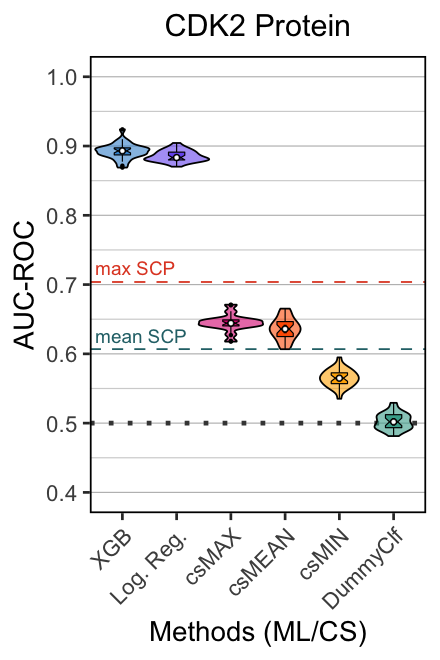

In [322]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.2) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
# ggsave(filename, plot=p, width=2.5, height= 3.3) 
p

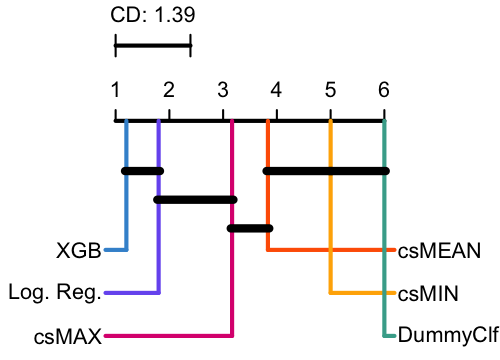

In [323]:
%%R -i df_R -i full_names -w 2.5 -h 1.8 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

# pdf(filename, 3, 1.2)
# plotCD_color(df_R, alpha=0.05, cex=.7, colPalette=cbbPalette, side_marging=5)
# dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, colPalette=cbbPalette, side_marging=4)

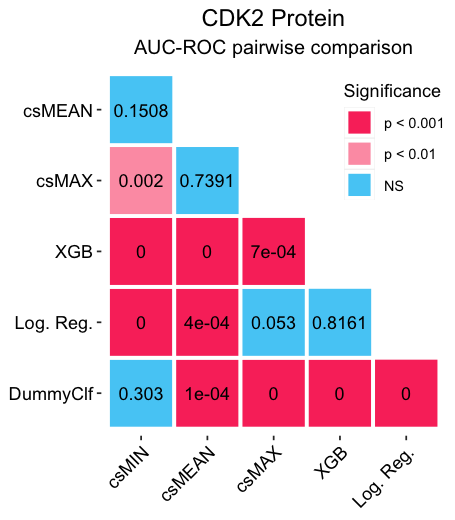

In [324]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
# ggsave(filename, plot=p, width=3.5, height= 4)
p

## pAUC-ROC Normalized

In [325]:
# Random value given n_a and N
test_size=0.25
N = y.size*0.25
n_a = y.sum()*0.25
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

866.5 103.75
Max pACU-ROC (non-normalized): 0.001154068090017311


0.14766080669711348

In [326]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(cv15x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv15x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv15x4.loc[metric_name]))

df_R = order_df(cv15x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
# single_mean, single_max = n_hold_out_single_performance(X, y, 
#                             metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,84.813961,8.235146e-17


,chi^2,dof,p_value
Friedman Test,150.0,5,1.335138e-30


In [327]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 200
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
#                dot_size=7, bin_width=0.002,
#                y_label='AUC-pROC', base_h_line=pROC_base_random) +
# add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
# add_ref_values('Sing. conf. max', single_max, color='coral1')

In [328]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
# plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [329]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

# plot_p_vals_heatmap(df_R)

## EF 12% = Ra

In [330]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(cv15x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv15x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv15x4.loc[metric_name]))

df_R = order_df(cv15x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

,Log. Reg.,XGB,DummyClf,csMEAN,csMAX,csMIN
Normality,1,1,1,1,1,1


,statistic,p
Bartlett,26.395131,0.000075


,chi^2,dof,p_value
Friedman Test,148.933333,5,2.251970e-30


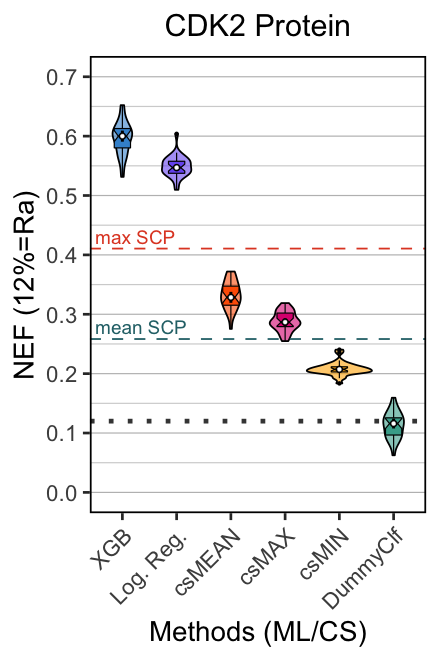

In [331]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.7,
              dot_size=4, scale='area', violin_width=1.2, base_h_line=R_a,
               y_label='NEF (12%=Ra)') +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

# Save the picture
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'NEF'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
# ggsave(filename, plot=p, width=2.5, height= 3.3) 
p

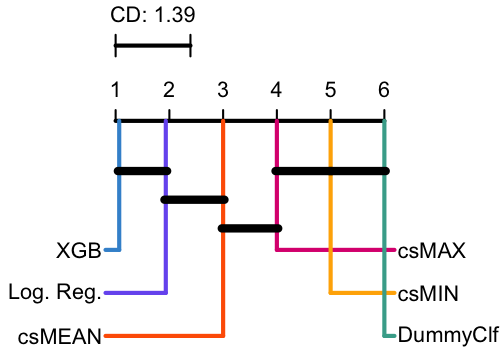

In [332]:
%%R -i df_R -i full_names -w 2.5 -h 1.8 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'NEF'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

# pdf(filename, 3, 1.2)
# plotCD_color(df_R, alpha=0.05, cex=.7, colPalette=cbbPalette, side_marging=5)
# dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, colPalette=cbbPalette, side_marging=4)

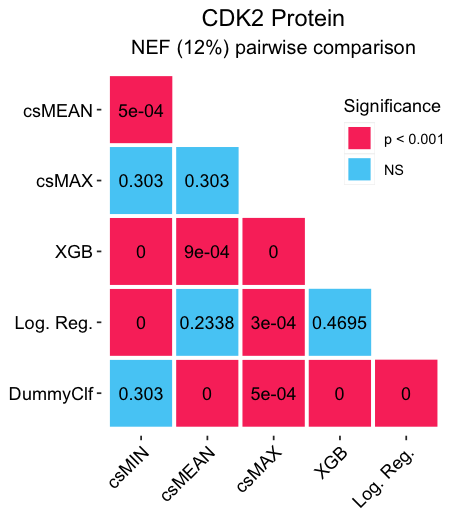

In [333]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='CDK2 Protein', subtitle="NEF (12%) pairwise comparison")

# Save the picture
protein_name <- 'cdk2'
methodology <- '15x4CV'
metric <- 'NEF'
filename <- paste0('images/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
# ggsave(filename, plot=p, width=3.5, height= 4)
p

# Y-randomization test

In [339]:
%%time 

n_repeats = 10
n_splits = 4

chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits,
                             y_preds_return=True)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 15.4 ms, sys: 4.22 ms, total: 19.6 ms
Wall time: 19.8 ms


## AUC-ROC

In [340]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

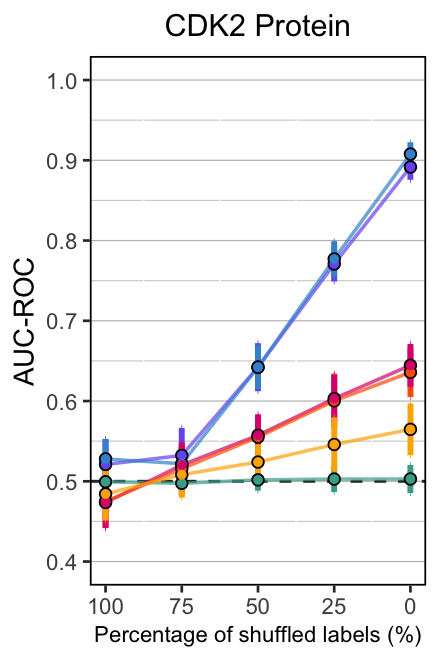

In [341]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

plot_lines(df_y_random, cbbPalette, point_size=1., line_size=0.6) +
ggtitle('CDK2 Protein')

## AUC-pROC Normalized

In [ ]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

In [ ]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

# plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
#                y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 12% 

In [342]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

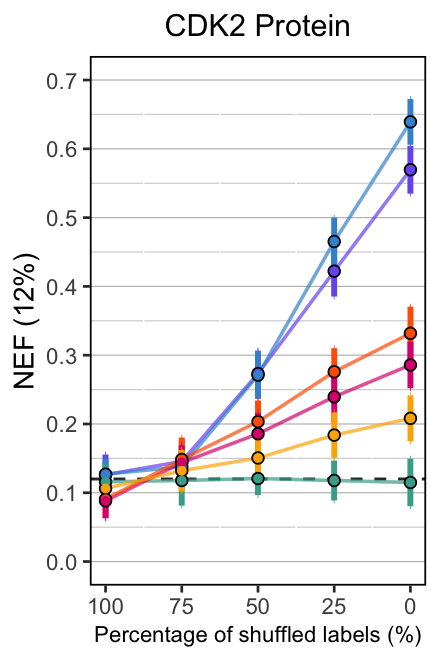

In [343]:
%%R -i df_y_random -i full_names -i df_R -i R_a -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

plot_lines(df_y_random, cbbPalette, point_size=1., line_size=0.6,
           y_min=0, y_max=0.7, base_h_line=R_a, y_label='NEF (12%)') +
ggtitle('CDK2 Protein')